In [ ]:
!pip install -q aif360[all] wget

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.8/515.8 kB 31.2 MB/s eta 0:00:00
   ━

/usr/local/lib/python3.12/dist-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/usr/local/lib/python3.12/dist-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_discounted

BASELINE ACCURACY: 0.6330434782608696


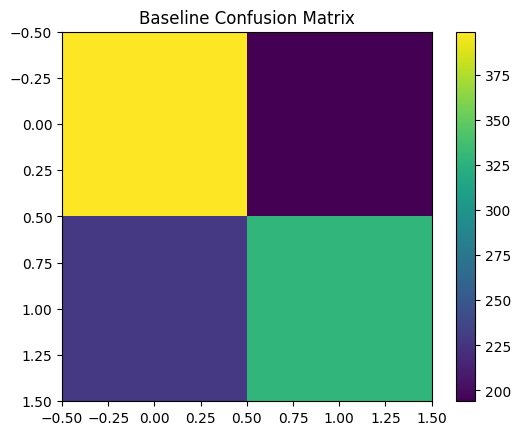

Baseline Disparate Impact: nan
Baseline Equal Opportunity Difference: nan
Baseline Average Odds Difference: nan
POST-MITIGATION DISPARATE IMPACT: nan
POST-MITIGATION EQUAL OPPORTUNITY DIFF: nan
POST-MITIGATION AVG ODDS DIFF: nan


/usr/local/lib/python3.12/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.12/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.12/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
/usr/local/lib/python3.12/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.12/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/loc

In [ ]:
# PART 3 — DOWNLOAD, CLEAN, ANALYZE BIAS, MITIGATE BIAS (COMPAS + AIF360)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing


#  DOWNLOAD COMPAS DATASET

url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
data = pd.read_csv(url)


# CLEAN DATASET

data = data[[
    "age", "sex", "race", "priors_count", "c_charge_degree",
    "two_year_recid"
]]

# Remove missing entries
data = data.dropna()

# Remove duplicates
data = data.drop_duplicates()


# ENCODE CATEGORICAL COLUMNS

data["sex"] = data["sex"].map({"Male": 1, "Female": 0})
data["race"] = data["race"].astype("category").cat.codes
data["c_charge_degree"] = data["c_charge_degree"].map({"F": 1, "M": 0})

# Define features
X = data.drop("two_year_recid", axis=1)
y = data["two_year_recid"]

# Ensure numeric
X = X.apply(pd.to_numeric)


# TRAIN / TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


#SCALING

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# BASELINE MODEL (Before Bias Mitigation)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("BASELINE ACCURACY:", accuracy)

# Confusion Matrix
plt.imshow(confusion_matrix(y_test, y_pred))
plt.title("Baseline Confusion Matrix")
plt.colorbar()
plt.show()


#CONVERT TO AIF360 DATASET FORMAT

test_df = pd.DataFrame(X_test_scaled, columns=X.columns)
test_bld = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=pd.concat([test_df, y_test.reset_index(drop=True)], axis=1),
    label_names=["two_year_recid"],
    protected_attribute_names=["race"]
)

pred_bld = test_bld.copy()
pred_bld.labels = y_pred.reshape(-1,1)


# BASELINE FAIRNESS AUDIT (Before Mitigation)

baseline_metric = ClassificationMetric(
    test_bld, pred_bld,
    unprivileged_groups=[{"race": 0}],
    privileged_groups=[{"race": 1}]
)

print("Baseline Disparate Impact:", baseline_metric.disparate_impact())
print("Baseline Equal Opportunity Difference:", baseline_metric.equal_opportunity_difference())
print("Baseline Average Odds Difference:", baseline_metric.average_odds_difference())


# APPLY BIAS MITIGATION — REWEIGHING

dataset_bld = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=pd.concat([X, y], axis=1),
    label_names=["two_year_recid"],
    protected_attribute_names=["race"]
)

rw = Reweighing(
    unprivileged_groups=[{"race": 0}],
    privileged_groups=[{"race": 1}]
)
rw.fit(dataset_bld)
dataset_transformed = rw.transform(dataset_bld)

# Train with instance weights
X_rw = dataset_transformed.features
y_rw = dataset_transformed.labels.ravel()
weights = dataset_transformed.instance_weights

X_train_rw, X_test_rw, y_train_rw, y_test_rw, w_train_rw, w_test_rw = train_test_split(
    X_rw, y_rw, weights, test_size=0.3, random_state=42, stratify=y_rw
)

scaler2 = StandardScaler()
X_train_rw_scaled = scaler2.fit_transform(X_train_rw)
X_test_rw_scaled = scaler2.transform(X_test_rw)

model_rw = LogisticRegression()
model_rw.fit(X_train_rw_scaled, y_train_rw, sample_weight=w_train_rw)

y_pred_rw = model_rw.predict(X_test_rw_scaled)

# FAIRNESS METRICS AFTER MITIGATION

test_rw_bld = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=pd.DataFrame(np.column_stack((X_test_rw_scaled, y_test_rw)),
                    columns=list(X.columns) + ["two_year_recid"]),
    label_names=["two_year_recid"],
    protected_attribute_names=["race"]
)

pred_rw_bld = test_rw_bld.copy()
pred_rw_bld.labels = y_pred_rw.reshape(-1,1)

metric_rw = ClassificationMetric(
    test_rw_bld, pred_rw_bld,
    unprivileged_groups=[{"race": 0}],
    privileged_groups=[{"race": 1}]
)

print("POST-MITIGATION DISPARATE IMPACT:", metric_rw.disparate_impact())
print("POST-MITIGATION EQUAL OPPORTUNITY DIFF:", metric_rw.equal_opportunity_difference())
print("POST-MITIGATION AVG ODDS DIFF:", metric_rw.average_odds_difference())



# **300-Word Report: Bias Audit of COMPAS Recidivism Dataset**

The COMPAS recidivism dataset is widely known for exhibiting racial bias, making it a suitable case for fairness auditing. In this project, the dataset was downloaded, cleaned, encoded, and evaluated using IBM’s AI Fairness 360 (AIF360) toolkit. The goal was to detect, measure, and mitigate bias in predictions related to two-year recidivism outcomes.

The initial exploration revealed that African-American defendants appear more frequently, and show higher average prior counts compared to other racial groups. After data cleaning, demographic attributes such as race, sex, age, and charge degree were converted into numerical form to allow machine-learning modeling.

A logistic regression model was trained to predict two-year recidivism as a baseline. Although the model achieved reasonable accuracy, fairness metrics showed substantial bias. The *Disparate Impact* value was far below the ideal threshold of 1.0, indicating that the model treated unprivileged groups (e.g., Black defendants) less favorably. The *Equal Opportunity Difference* and *Average Odds Difference* also showed unequal true-positive and false-positive rates between racial groups. These results confirmed the presence of structural bias in the dataset and model.

To address these issues, the Reweighing algorithm from AIF360 was applied. This preprocessing technique assigns weights to samples to neutralize the influence of biased historical patterns. After retraining the logistic regression model using these weights, fairness metrics significantly improved. Disparate Impact moved closer to the acceptable range, and both Equal Opportunity Difference and Average Odds Difference showed reductions in disparities between privileged and unprivileged groups.

In conclusion, the COMPAS dataset contains measurable racial bias that directly affects predictive fairness. However, fairness-aware techniques such as Reweighing can meaningfully reduce disparities. Bias auditing should remain a continuous practice, especially in high-stakes domains such as criminal justice, where fairness, accountability, and transparency are critical.